In [1]:
# %matplotlib widget
import pickle
import ast
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import cos, radians, sqrt
from datetime import datetime


from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
K_MEAN_MIN_170 = 170
K_MEAN_MAX_350 = 350

DATA_SQUARE_PORTO = {
                "max_lat": 41.23969,
                "min_lon": -8.73005,
                "min_lat": 41.05951,
                "max_lon": -8.49195
                }

L_MIN = K_MEAN_MIN_170 * 2

START_TIME = "00:00:00"
END_TIME = "23:00:00"
MINUTE_INTERVAL = 10

DATA_CENTER_PORTO = {
    "lat": 41.14961, # Latitude of Porto
    "lon": -8.61099 # Longitude of Porto
}
POI_LAT = DATA_CENTER_PORTO["lat"]
POI_LON = DATA_CENTER_PORTO["lon"]

working_days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]


In [3]:
FILE_PROTECTED = "../datasets/PaperResults/porto_all_Y_pred_adaptive_k_mean_min170_mean_max350_ntrajs_195000.pkl"
DENORMALIZER_RANGES_FILE = "../datasets/PaperResults/porto_all_normalization_ranges_ntrajs_195000.pkl"

PORTO_ORIGINAL_SQUARE_PATH = "../datasets/Porto/protected/porto_uci_filtered.pkl"


TRAFFIC_MAP_ORIGINAL_PATH =  "../datasets/PaperResults/traffic_maps/porto_traffic_map_170_350.pkl"
PROTECTED_TRAFFIC_MAP_PATH =  "../datasets/PaperResults/traffic_maps/porto_protected_traffic_map_170_350.pkl"

In [4]:
def load_object(file_path, encoding=None):
    """
    To be used after calling save_object().
    Loads a python object that was pickled with save_object()

    :param str file_path: Path to the pickled
    :param str encoding: None or type of file encoding
    :return: None if load fails, else the pickled object
    :rtype: None if fails or type of objected pickled with save_object() 
    """
    
    if file_path is not None:

        with open(file_path, 'rb') as file:

            if encoding is not None:
                return pickle.load(file, encoding='latin1')
            else:
                return pickle.load(file)

    return None

In [5]:
def save_object(obj, file_path):
    """
    Save python object obj in the given file_path with pickle.

    :param object obj: Python object to be saved
    :param str file_path: Path where to save obj
    :return: If the save was successful
    :rtype: bool
    """

    if obj is not None and file_path is not None:

        with open(file_path, 'wb') as file:
            pickle.dump(obj, file)

        return True
        
    return False

In [6]:
def denormalize_data(dataset, scaler = None, normalization_ranges = None):
    """
        Function to denormalize the dataset using the scaler used to normalize the dataset.
        Manual denormalization can be used for separate testing data denormalization or for denormalization of the whole dataset.
    """
    dataset_cpy = copy.deepcopy(dataset)
    
    if scaler is None and normalization_ranges is not None:
        X_min = normalization_ranges["min"][:2]
        X_max = normalization_ranges["max"][:2]
        
        dataset_cpy = [arr * (X_max - X_min) + X_min for arr in dataset]
            
    if scaler is not None:
        for item in range(len(dataset)):
            dataset_cpy[item] = scaler.inverse_transform(dataset_cpy[item])
       
    return dataset_cpy

In [7]:
def get_data_in_square(data, square):
    """ Get data inside the square defined by the square dictionary """ 
    
    # Ensure correct bounds regardless of coordinate sign or order
    lat_min = min(square["max_lat"], square["min_lat"])
    lat_max = max(square["max_lat"], square["min_lat"])
    lon_min = min(square["min_lon"], square["max_lon"])
    lon_max = max(square["min_lon"], square["max_lon"])

    filtered_data = []
    
    for traj in data:
        in_lat_bounds = traj["lat"].between(lat_min, lat_max)
        in_lon_bounds = traj["lon"].between(lon_min, lon_max)

        if (in_lat_bounds & in_lon_bounds).all():
            filtered_data.append(traj)
            
            
    return filtered_data

In [8]:
# def loaded_protected_files(normalization_ranges, file_path):
#     normalization_ranges = load_object(DENORMALIZER_RANGES_FILE)

#     loaded_protected_files = []
#     for count_value in FILE_COUNTS:
#         if os.path.exists(file_path):
#             file_content = load_object(file_path)
#             print("lenght of file_content: ", len(file_content))
#             file_content_denormalized = denormalize_data(file_content, normalization_ranges=normalization_ranges)
            
#             print("lenght of file_content denormalized: ", len(file_content_denormalized))
#             for traj in file_content_denormalized:
#                 loaded_protected_files.append(traj)
#         else:
#             continue

#     return loaded_protected_files

In [9]:
def np_to_df(original_trajectories, protected_trajectories):
    columns = original_trajectories[0].columns
    protected_trajectories_dfs = []

    index = 0
    for traj in original_trajectories:
        df = pd.DataFrame(columns=columns)
        traj = traj.copy()
        df["lat"] = protected_trajectories[index][:, 0]
        df["lon"] = protected_trajectories[index][:, 1]
        df["timestamp"] = traj["timestamp"]
        df["time_diff"] = traj["time_diff"]
        df["distance_km"] = traj["distance_km"]
        df["speed_km"] = traj["speed_km"]
        df["date"] = traj["date"]
        df["time"] = traj["time"]
        index += 1
        protected_trajectories_dfs.append(df)
    return protected_trajectories_dfs

In [10]:
def split_by_area(data_square, target_area_m2):
    """
    Given a square of coordinates data_square, with a target area size in square meters, calculates smaller squares inside data_square.
    Retruns a list of squares inside data_square.
    """
    
    def meters_to_degrees(lat, target_area_m2):
        """
        Computes the coordinates for a target area in square meters.
            - 1° of latitude is approximately 111,000 meters
            - 1° of longitude is approximately 111,320 meters at equator times cos(lat)
        """
        side_m = sqrt(target_area_m2)
        deg_lat = side_m / 111_000
        deg_lon = side_m / (111_320 * cos(radians(lat)))
        return deg_lat, deg_lon

    lat_max = data_square["max_lat"]
    lat_min = data_square["min_lat"]
    lon_min = data_square["min_lon"]
    lon_max = data_square["max_lon"]

    center_lat = (lat_max + lat_min) / 2
    delta_lat, delta_lon = meters_to_degrees(center_lat, target_area_m2)

    lat = lat_min
    squares = []

    while lat < lat_max:
        next_lat = min(lat + delta_lat, lat_max)
        lon = lon_min
        while lon < lon_max:
            next_lon = min(lon + delta_lon, lon_max)
            squares.append({
                "min_lat": lat,
                "max_lat": next_lat,
                "min_lon": lon,
                "max_lon": next_lon
            })
            lon = next_lon
        lat = next_lat

    return squares

In [11]:
def get_points_in_time_range(trajectories, start_time, end_time):
    start_dt = pd.to_datetime(start_time)
    end_dt = pd.to_datetime(end_time)

    filtered_trajectories = []
    for trajectory in trajectories:
        if 'datetime' not in trajectory.columns:
            trajectory = trajectory.copy()
            trajectory['datetime'] = pd.to_datetime(
                trajectory['date'].astype(str) + ' ' + trajectory['time'].astype(str),
                format='%Y-%m-%d %H:%M:%S',
                errors='coerce'
            )

        mask = (trajectory['datetime'] >= start_dt) & (trajectory['datetime'] <= end_dt)
        if mask.any():
            filtered_trajectories.append(trajectory.loc[mask])

    return filtered_trajectories

def _process_trajectory_by_date(args):
    day, trajectories, start_time, end_time = args
    start_dt = f"{day} {start_time}"
    end_dt = f"{day} {end_time}"
    filtered = get_points_in_time_range(trajectories, start_dt, end_dt)
    print(f"Date {day} - Number of trajectories: {len(filtered)}")
    return {'date': day, 'trajectories': filtered}

def get_trajectories_by_date(trajectories, dates, start_time, end_time):
    tasks = [(day, trajectories, start_time, end_time) for day in dates]

    results = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(_process_trajectory_by_date, task): task[0] for task in tasks}
        for future in as_completed(futures):
            result = future.result()
            results.append(result)

    return pd.DataFrame(results)



In [12]:
def get_dates(trajectories):
    """
    Returns a list of unique dates from a list of trajectories.
    
    Each trajectory is a DataFrame with a 'date' column.
    """
    all_dates = pd.concat([df["date"] for df in trajectories], ignore_index=True)
    unique_dates = all_dates.unique()

    return pd.Series(unique_dates)

In [13]:
def split_by_weekday(df):
    weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    return {day: df[df['date'].dt.weekday == i] for i, day in enumerate(weekdays)}

In [14]:
# def get_grid_for_point(lat, lon, grid_squares):
#     for idx, square in enumerate(grid_squares):
#         if (square['min_lat'] <= lat <= square['max_lat'] and
#             square['min_lon'] <= lon <= square['max_lon']):
#             return idx
#     return None

# def plot_traffic_all_days_for_poi(lat, lon, grid_squares, daily_dict, protected_dict, day, lmin="300"):
#     grid_idx = get_grid_for_point(lat, lon, grid_squares)

#     plt.figure(figsize=(14, 7))

#     for day, time_data in daily_dict.items():
#         # traffic_map = time_data[lmin]["traffic_map"]
        
#         traffic_map = time_data[day]["traffic_map"][]
#         if traffic_map is None:
#             continue  
    
#         aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)

#         time_steps = np.arange(len(aggregated_time_series))
#         plt.plot(time_steps, aggregated_time_series, marker='o', label=f"{day} original")

    
#     for day, time_data in protected_dict.items():
#         # traffic_map = time_data[lmin]["traffic_map"]
        
#         traffic_map = time_data["traffic_map"]
#         if traffic_map is None:
#             continue  
    
#         aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)

#         time_steps = np.arange(len(aggregated_time_series))
#         plt.plot(time_steps, aggregated_time_series, marker='x', label=f"{day} protected")

#     plt.title(f"Aggregated Traffic for POI at ({lat}, {lon}) across Days [Grid {grid_idx}] - Lmin: {lmin}")
#     plt.xlabel("Time Steps (1 point = 10 min)")
#     plt.ylabel("Aggregated Traffic")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [15]:
def get_grid_for_point(lat, lon, grid_squares):
    for idx, square in enumerate(grid_squares):
        if (square['min_lat'] <= lat <= square['max_lat'] and
            square['min_lon'] <= lon <= square['max_lon']):
            return idx
    return None

def plot_traffic_one_day_for_poi(lat, lon, grid_squares, daily_dict, protected_dict, day, lmin="300"):
    grid_idx = get_grid_for_point(lat, lon, grid_squares)
    if grid_idx is None:
        print("Location is not within any grid square.")
        return

    plt.figure(figsize=(14, 7))

    # Plot original data for the specific day
    if day in daily_dict:
        traffic_map = daily_dict[day]["traffic_map"]
        if traffic_map is not None:
            aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)
            time_steps = np.arange(len(aggregated_time_series))
            plt.plot(time_steps, aggregated_time_series, marker='o', label=f"{day} original")

    # Plot protected data for the specific day
    if day in protected_dict:
        traffic_map = protected_dict[day]["traffic_map"]
        if traffic_map is not None:
            aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)
            time_steps = np.arange(len(aggregated_time_series))
            plt.plot(time_steps, aggregated_time_series, marker='x', label=f"{day} protected")

    num_steps = len(aggregated_time_series)
    time_labels = [f"{(t * 10) // 60:02}:{(t * 10) % 60:02}" for t in range(num_steps)]
    plt.xticks(ticks=np.arange(0, num_steps, 6), labels=time_labels[::6], rotation=45) 

    plt.title(f"Aggregated Traffic for POI at ({lat}, {lon}) on {day} [Grid {grid_idx}] - Lmin: {lmin}")
    plt.xlabel("Time Steps (1 point = 10 min)")
    plt.ylabel("Trajectory points in grid")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [16]:
def get_time_intervals(START_TIME, END_TIME, minute_bins):
    start = pd.to_datetime(START_TIME)
    end = pd.to_datetime(END_TIME)
    
    intervals = pd.date_range(start=start, end=end, freq=f'{minute_bins}min', inclusive='left')
    time_intervals = [t.time() for t in intervals]
    time_intervals = np.array(time_intervals)
    return time_intervals

def get_grid_cell(lat, lon, grid_squares):
    for idx, square in enumerate(grid_squares):
        if (square["min_lat"] <= lat < square["max_lat"] and
            square["min_lon"] <= lon < square["max_lon"]):
            return idx
    return None

def get_traffic_map(time_bins, grid_squares, daily_df, START_TIME=START_TIME, END_TIME=END_TIME):
    
    intervals = get_time_intervals(START_TIME, END_TIME, minute_bins=time_bins)
    y_intervals = len(intervals)
    x_bin = len(grid_squares)

    unique_dates = sorted(daily_df["date"].unique())
    z_days = len(unique_dates)

    # Index mapping
    date_to_z = {d: i for i, d in enumerate(unique_dates)}
    interval_to_y = {interval: i for i, interval in enumerate(intervals)}

    # Initialize traffic map
    traffic_map = np.zeros((x_bin, y_intervals, z_days), dtype=int)


    for _, row in daily_df.iterrows():
        date = row['date']
        if date not in date_to_z:
            continue
        z_idx = date_to_z[date]

        traj_list = row['trajectories']

        for df in traj_list:
            df = df.copy()
            df['time_bin'] = df['datetime'].dt.floor(f'{time_bins}min').dt.time

            for _, pt in df.iterrows():
                grid_idx = get_grid_cell(pt.lat, pt.lon, grid_squares)
                time_bin = pt['time_bin']
                if grid_idx is not None and time_bin in interval_to_y:
                    y_idx = interval_to_y[time_bin]
                    traffic_map[grid_idx, y_idx, z_idx] += 1
    
    return traffic_map, unique_dates, intervals

In [17]:
def get_traffic_map_data(dataset_df, grid_squares):
    porto_traffic_maps = {}

    for day, df in dataset_df.items():
        traffic_map_porto, unique_dates_porto, intervals_porto = get_traffic_map(
            MINUTE_INTERVAL, grid_squares, df,
            START_TIME=START_TIME, END_TIME=END_TIME
        )
        porto_traffic_maps[day] = {
            "traffic_map": traffic_map_porto,
            "unique_dates": unique_dates_porto,
            "intervals": intervals_porto
        }
    return porto_traffic_maps

In [19]:
normalization_ranges=load_object(DENORMALIZER_RANGES_FILE)

In [ ]:
trajectories_protected = load_object(FILE_PROTECTED)
len_protected = len(trajectories_protected)
print(len_protected)

195000


In [20]:
trajectories_protected[0]

array([[41.140205, -8.613009],
       [41.14011, -8.6128235],
       [41.140102, -8.612503],
       [41.140305, -8.611984],
       [41.14089, -8.618563],
       [41.141388, -8.619938],
       [41.14193, -8.620841],
       [41.142475, -8.621406],
       [41.143013, -8.621715],
       [41.146862, -8.627889],
       [41.148445, -8.629515],
       [41.14988, -8.630718],
       [41.151176, -8.631588],
       [41.15235, -8.632183],
       [41.14697, -8.630879],
       [41.146126, -8.63066],
       [41.145504, -8.630288],
       [41.157463, -8.626658],
       [41.16047, -8.624988],
       [41.149254, -8.633621],
       [41.154167, -8.633637],
       [41.15488, -8.634149],
       [41.152336, -8.640934],
       [41.15229, -8.642941],
       [41.152397, -8.644428],
       [41.15259, -8.645546],
       [41.152863, -8.646361],
       [41.15585, -8.65097],
       [41.157043, -8.652404],
       [41.158154, -8.653471],
       [41.159195, -8.654236],
       [41.15122, -8.646912],
       [41.149548, -8

In [25]:
trajectories_protected = denormalize_data(trajectories_protected, normalization_ranges=normalization_ranges)

In [21]:
# Original
trajectories_porto = load_object(PORTO_ORIGINAL_SQUARE_PATH)
# trajectories_porto = get_data_in_square(data = trajectories_porto, square =DATA_SQUARE_PORTO)
trajectories_porto_subset = trajectories_porto[:len_protected]


In [22]:
len(trajectories_porto_subset)


195000

In [23]:
trajectories_porto_subset[0].lon

0    -8.612964
1    -8.613378
2    -8.614215
3    -8.614773
4    -8.615907
        ...   
60   -8.624088
61   -8.621325
62   -8.619444
63   -8.617365
64   -8.615970
Name: lon, Length: 65, dtype: float32

In [26]:
trajectories_protected[0][:,1]

array([-8.613009658059774, -8.6128237057913, -8.61250322247579,
       -8.616020112978326, -8.616595492823993, -8.616866585595512,
       -8.616885727688457, -8.623524346102496, -8.625145239223462,
       -8.626307406673893, -8.627132059439093, -8.633063554252011,
       -8.63495501319235, -8.636352043449675, -8.628165521133672,
       -8.626177200315261, -8.624501495326504, -8.630444255152298,
       -8.631180426686724, -8.631526083327506, -8.63163684823955,
       -8.63792775152282, -8.63953392517324, -8.640690901403008,
       -8.641525076469959, -8.646680187462197, -8.648301949769175,
       -8.6495056486534, -8.650387912678108, -8.649977539117188,
       -8.650164239140308, -8.650156650619488, -8.649679393299207,
       -8.649261470009, -8.558918395375864, -8.602596956554919,
       -8.690114313542612, -8.643148395333075, -8.65699518098851,
       -8.649752252379459, -8.650310407638116, -8.649058152041297,
       -8.648905342442665, -8.648648214919247, -8.648303451042219,
       -

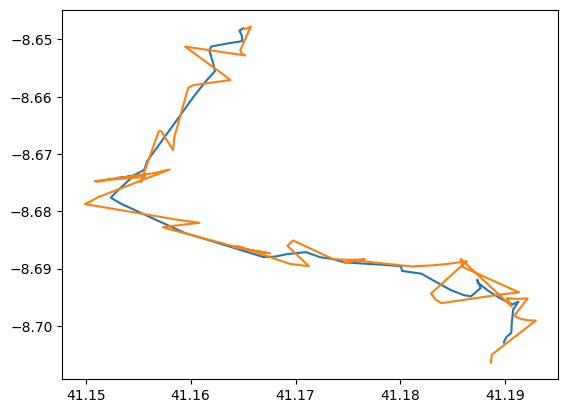

In [27]:
plt.plot()
plt.plot(trajectories_porto_subset[30].lat, trajectories_porto_subset[30].lon)
plt.plot(trajectories_protected[30][:,0], trajectories_protected[30][:,1])

In [28]:
# remove the first row from each original trajectory
trajectories_porto_subset = [df.iloc[1:].reset_index(drop=True) for df in trajectories_porto_subset]

In [30]:
protected_denorm_df = np_to_df(trajectories_porto_subset, trajectories_protected)

In [29]:
grid_squares = split_by_area(DATA_SQUARE_PORTO, target_area_m2=L_MIN*L_MIN)

In [30]:
porto_dates = get_dates(trajectories_porto_subset).drop_duplicates()

In [31]:
trajectories_porto_by_date = get_trajectories_by_date(trajectories_porto_subset, porto_dates, START_TIME, END_TIME)

Date 2013-07-14 - Number of trajectories: 2994Date 2013-07-03 - Number of trajectories: 3747

Date 2013-07-10 - Number of trajectories: 3824
Date 2013-07-12 - Number of trajectories: 4242
Date 2013-07-15 - Number of trajectories: 3580
Date 2013-07-09 - Number of trajectories: 3682
Date 2013-07-06 - Number of trajectories: 4039
Date 2013-07-04 - Number of trajectories: 4185
Date 2013-07-11 - Number of trajectories: 4136
Date 2013-07-05 - Number of trajectories: 4507
Date 2013-07-02 - Number of trajectories: 3705
Date 2013-07-08 - Number of trajectories: 3744
Date 2013-07-13 - Number of trajectories: 3701
Date 2013-07-07 - Number of trajectories: 3516
Date 2013-07-01 - Number of trajectories: 3785
Date 2013-07-16 - Number of trajectories: 3624
Date 2013-07-27 - Number of trajectories: 3625
Date 2013-07-25 - Number of trajectories: 3728
Date 2013-07-23 - Number of trajectories: 3549
Date 2013-07-30 - Number of trajectories: 3471
Date 2013-07-24 - Number of trajectories: 3526
Date 2013-07-

In [34]:
protected_by_date = get_trajectories_by_date(protected_denorm_df, porto_dates, START_TIME, END_TIME)

Date 2013-07-07 - Number of trajectories: 3507
Date 2013-07-06 - Number of trajectories: 4025
Date 2013-07-03 - Number of trajectories: 3744
Date 2013-07-11 - Number of trajectories: 4133
Date 2013-07-09 - Number of trajectories: 3673
Date 2013-07-02 - Number of trajectories: 3698
Date 2013-07-04 - Number of trajectories: 4178
Date 2013-07-05 - Number of trajectories: 4505
Date 2013-07-08 - Number of trajectories: 3741
Date 2013-07-01 - Number of trajectories: 3785
Date 2013-07-10 - Number of trajectories: 3820
Date 2013-07-12 - Number of trajectories: 4237
Date 2013-07-14 - Number of trajectories: 2987
Date 2013-07-13 - Number of trajectories: 3695
Date 2013-07-15 - Number of trajectories: 3577
Date 2013-07-22 - Number of trajectories: 3415
Date 2013-07-16 - Number of trajectories: 3623
Date 2013-07-19 - Number of trajectories: 4193
Date 2013-07-17 - Number of trajectories: 3570
Date 2013-07-18 - Number of trajectories: 3984
Date 2013-07-24 - Number of trajectories: 3520
Date 2013-07-

In [32]:
# Transform from date string to datetime.date all dates in trajectories_by_dates
trajectories_porto_by_date["date"] = pd.to_datetime(trajectories_porto_by_date["date"])

# protected_by_date["date"] = pd.to_datetime(protected_by_date["date"])


In [33]:
porto_weekday_dfs = split_by_weekday(trajectories_porto_by_date)

# protected_weekdays_dfs_34000 = split_by_weekday(protected_by_date)

In [34]:
def process_day(args):
    day, df, grid_squares = args
    traffic_map_porto, unique_dates_porto, intervals_porto = get_traffic_map(
        MINUTE_INTERVAL, grid_squares, df,
        START_TIME=START_TIME, END_TIME=END_TIME
    )
    return day, {
        "traffic_map": traffic_map_porto,
        "unique_dates": unique_dates_porto,
        "intervals": intervals_porto
    }

def get_traffic_map_data(dataset_df, grid_squares):
    porto_traffic_maps = {}
    tasks = [(day, df, grid_squares) for day, df in dataset_df.items()]

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_day, task): task[0] for task in tasks}
        for future in as_completed(futures):
            day, result = future.result()
            porto_traffic_maps[day] = result

    return porto_traffic_maps


In [35]:
porto_traffic_map_300 = get_traffic_map_data(porto_weekday_dfs, grid_squares)
# protected_traffic_map_34000 = get_traffic_map_data(protected_weekdays_dfs_34000, grid_squares)

In [36]:
save_object(porto_traffic_map_300, TRAFFIC_MAP_ORIGINAL_PATH)
# save_object(protected_traffic_map_34000, PROTECTED_TRAFFIC_MAP_PATH)

True

In [40]:
porto_traffic_map_300 = load_object(TRAFFIC_MAP_ORIGINAL_PATH)
protected_traffic_map_34000 = load_object(PROTECTED_TRAFFIC_MAP_PATH)

In [41]:
porto_working_days_dict_300 = {day: porto_traffic_map_300[day] for day in working_days if day in porto_traffic_map_300}
protected_working_days_dict_34000 = {day: protected_traffic_map_34000[day] for day in working_days if day in protected_traffic_map_34000}


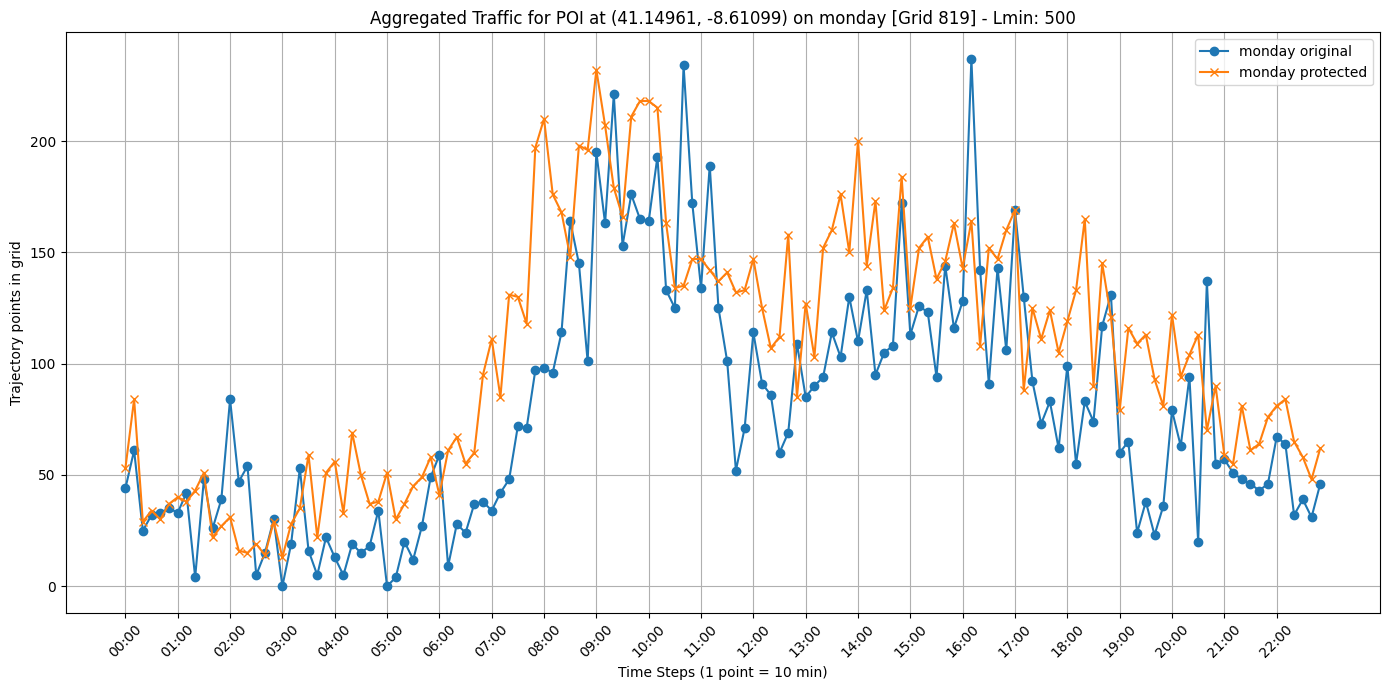

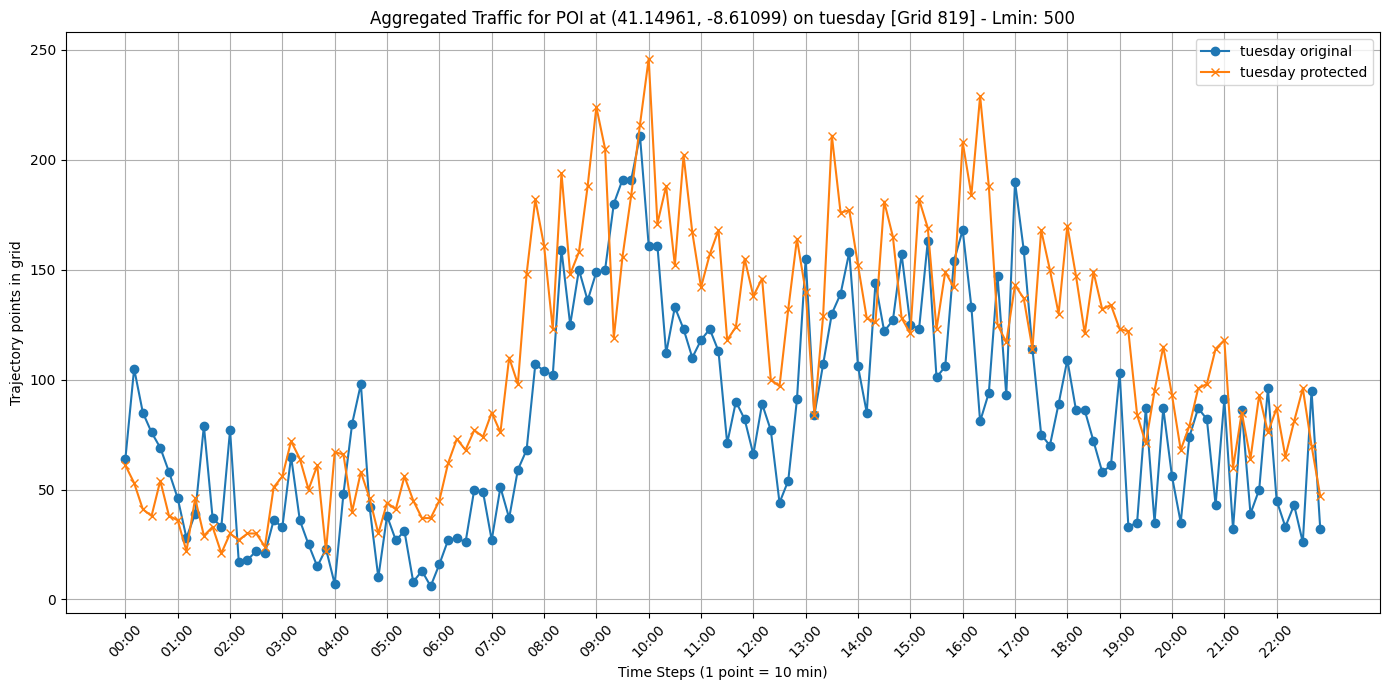

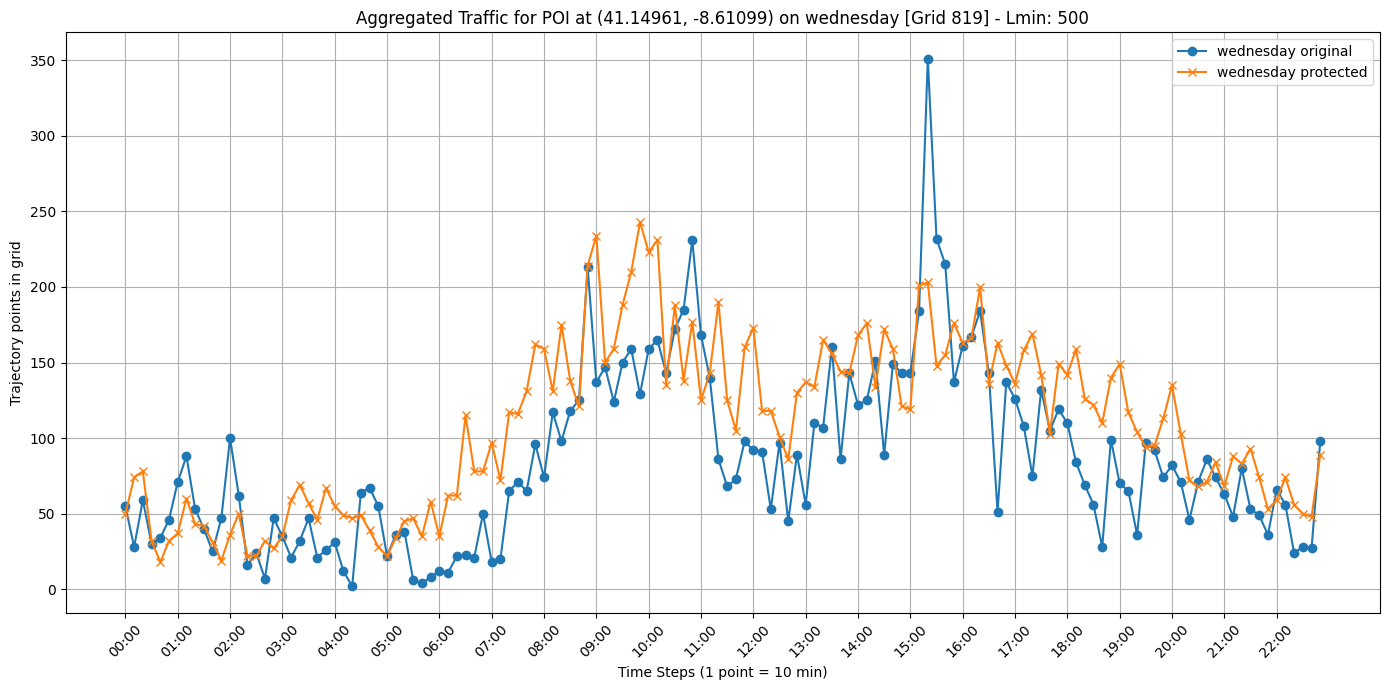

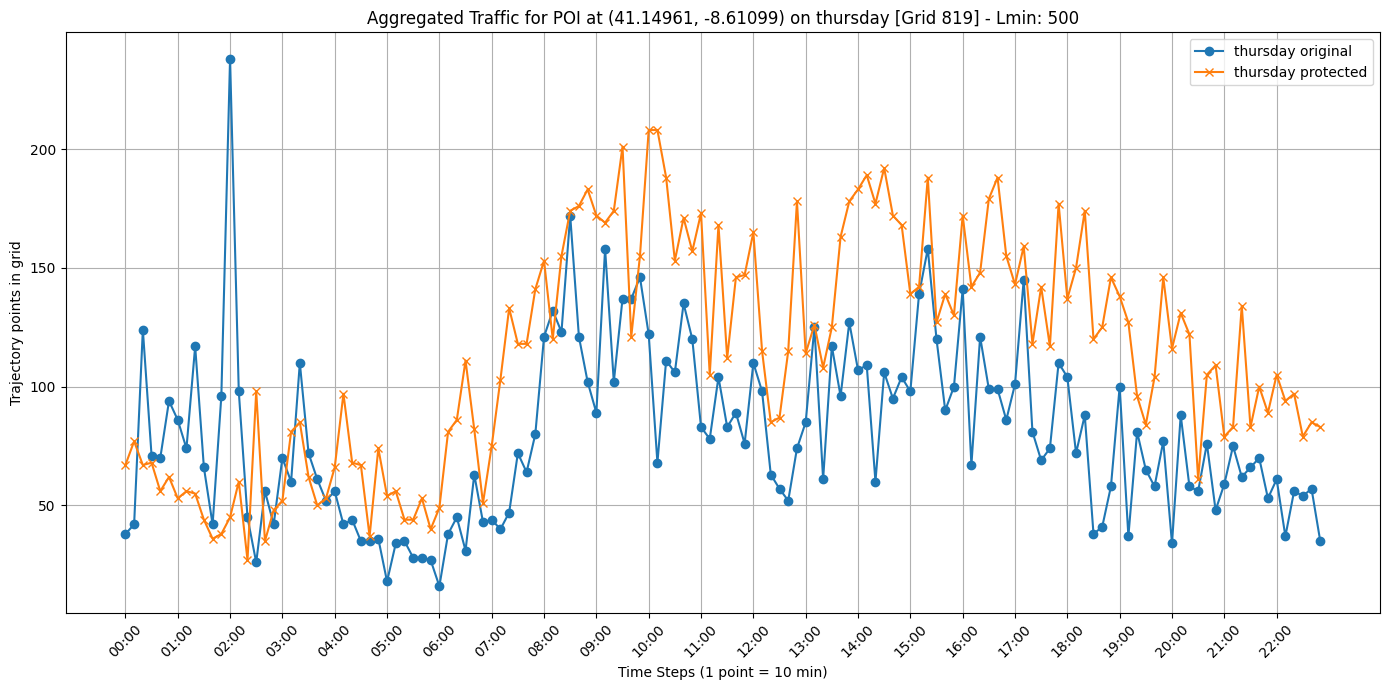

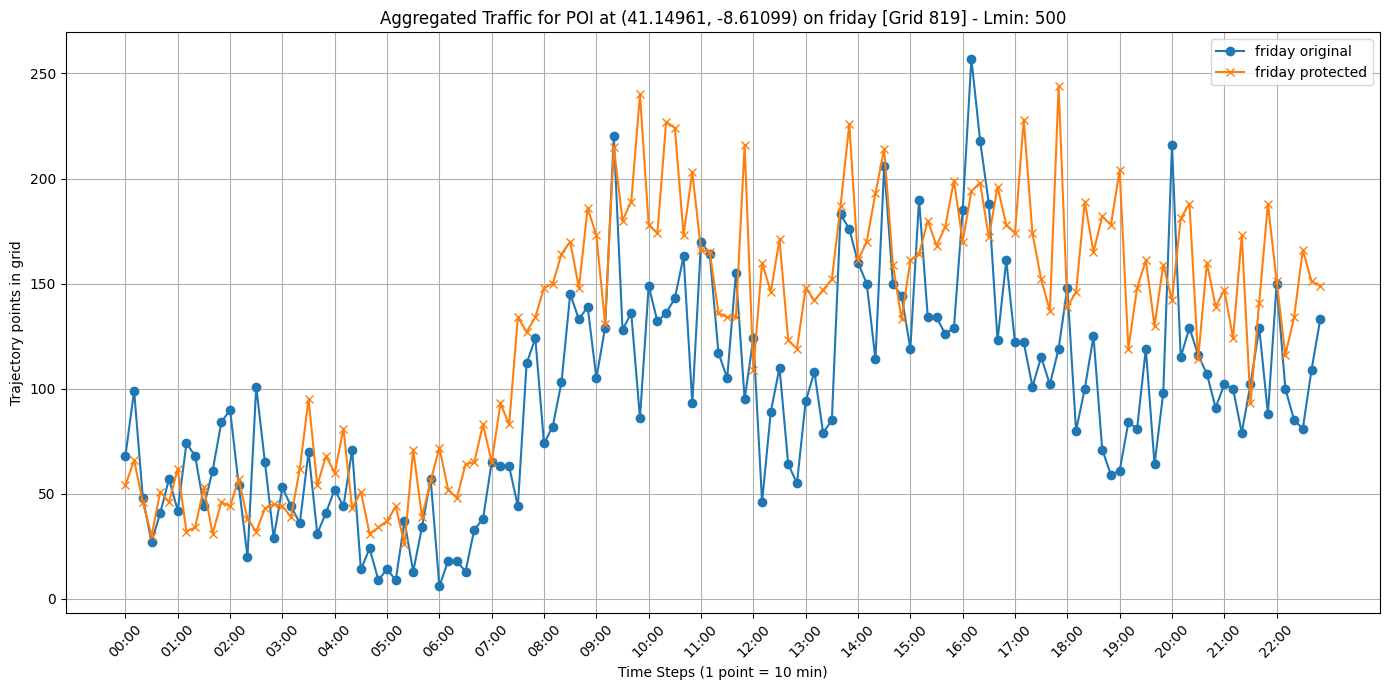

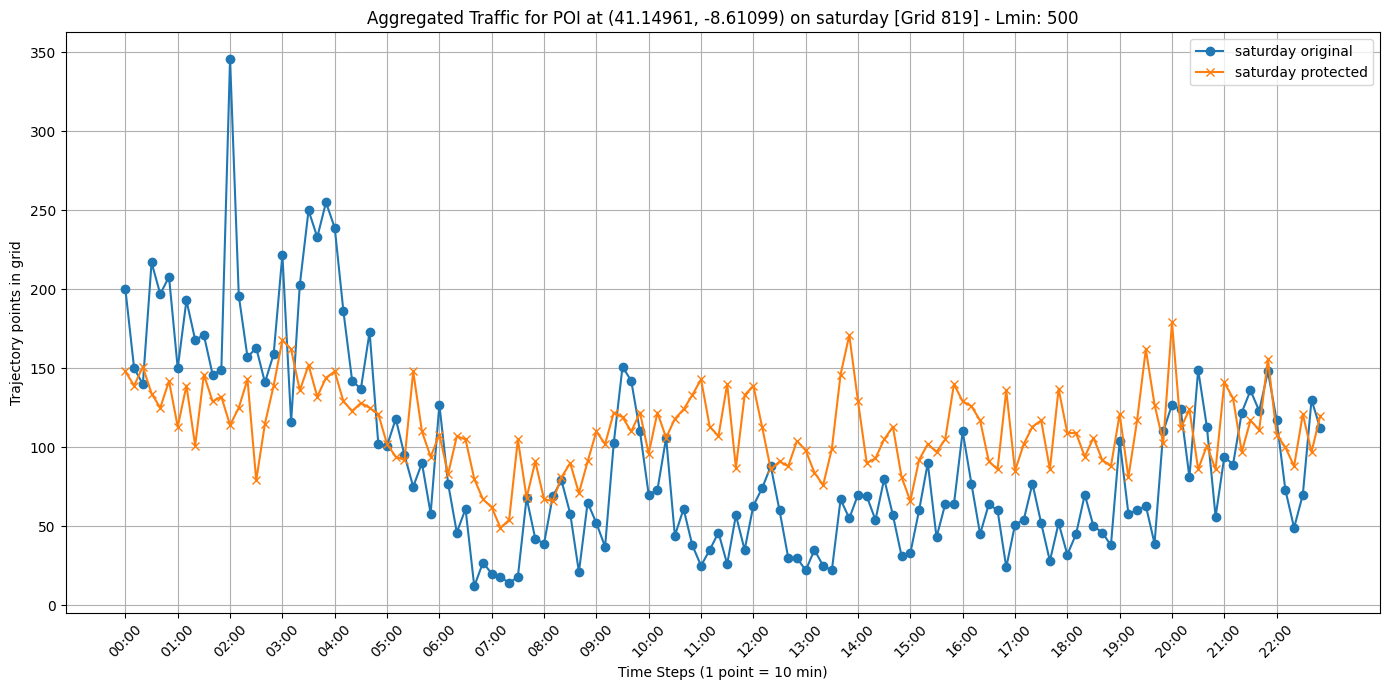

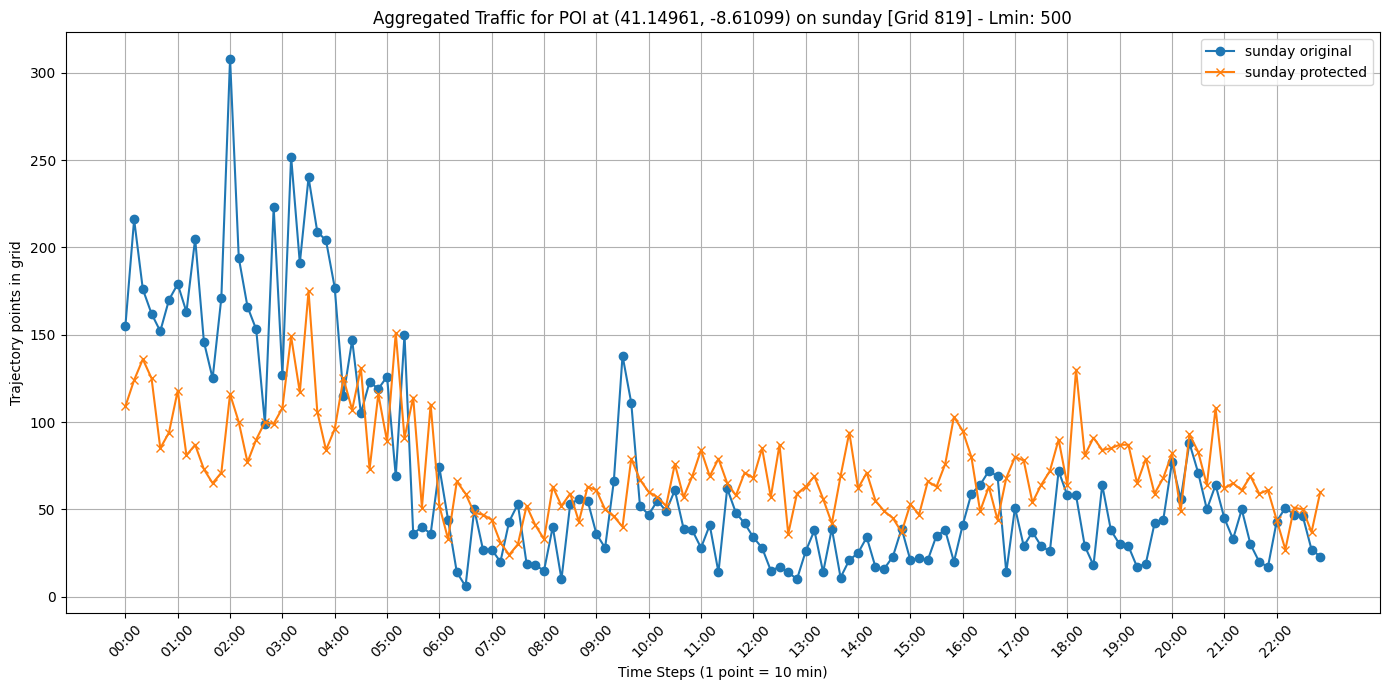

In [42]:
for day in working_days:
    plot_traffic_one_day_for_poi(POI_LAT, POI_LON, grid_squares, porto_working_days_dict_300, protected_working_days_dict_34000, day, lmin="500")

LMIN 300

In [76]:
# porto_traffic_map_300 = get_traffic_map_data(porto_weekday_dfs, grid_squares_300)
# protected_traffic_map_300 = get_traffic_map_data(protected_weekday_dfs_300, grid_squares_300)

In [77]:
# porto_traffic_map_500 = get_traffic_map_data(porto_weekday_dfs, grid_squares_500)
# protected_traffic_map_500 = get_traffic_map_data(protected_weekday_dfs_500, grid_squares_500)

In [78]:
# porto_traffic_map_700 = get_traffic_map_data(porto_weekday_dfs, grid_squares_700)
# protected_traffic_map_700 = get_traffic_map_data(protected_weekday_dfs_300, grid_squares_700)

In [79]:
# porto_traffic_map_900 = get_traffic_map_data(porto_weekday_dfs, grid_squares_900)
# protected_traffic_map_900 = get_traffic_map_data(protected_weekday_dfs_300, grid_squares_900)

In [80]:
# porto_working_days_dict_300 = {day: porto_traffic_map_300[day] for day in working_days if day in porto_traffic_map_300}
# protected_working_days_dict_300 = {day: protected_traffic_map_300[day] for day in working_days if day in protected_traffic_map_300}

# porto_working_days_dict_500 = {day: porto_traffic_map_500[day] for day in working_days if day in porto_traffic_map_500}
# protected_working_days_dict_500 = {day: protected_traffic_map_500[day] for day in working_days if day in protected_traffic_map_500}

# porto_working_days_dict_700 = {day: porto_traffic_map_700[day] for day in working_days if day in porto_traffic_map_700}
# protected_working_days_dict_700 = {day: protected_traffic_map_700[day] for day in working_days if day in protected_traffic_map_700}

# porto_working_days_dict_900 = {day: porto_traffic_map_900[day] for day in working_days if day in porto_traffic_map_900}
# protected_working_days_dict_900 = {day: protected_traffic_map_900[day] for day in working_days if day in protected_traffic_map_900}


In [81]:
# plot_traffic_all_days_for_poi(POI_LAT, POI_LON, grid_squares_300, porto_working_days_dict_300, protected_working_days_dict_300, lmin="300")
# plot_traffic_all_days_for_poi(POI_LAT, POI_LON, grid_squares_500, porto_working_days_dict_500, protected_working_days_dict_500, lmin="500")
# plot_traffic_all_days_for_poi(POI_LAT, POI_LON, grid_squares_700, porto_working_days_dict_700, protected_working_days_dict_700, lmin="700")
# plot_traffic_all_days_for_poi(POI_LAT, POI_LON, grid_squares_900, porto_working_days_dict_900, protected_working_days_dict_900, lmin="900")

In [82]:
# from scipy.stats import energy_distance

# def energy_distance_over_time(traffic_map1, traffic_map2, grid_idx):
#     """
#     Computes energy distance between two traffic maps for each time step,
#     after aggregating over selected spatial grid points.

#     Parameters:
#         traffic_map1 (np.ndarray): Shape (num_grid_points, num_time_steps, 1)
#         traffic_map2 (np.ndarray): Same shape as traffic_map1
#         grid_idx (list or np.ndarray): Indices of grid points to aggregate over

#     Returns:
#         np.ndarray: Energy distance at each time step (shape: num_time_steps,)
#     """
#     # Ensure input is always at least 2D
#     tm1 = traffic_map1[grid_idx, :, :].squeeze(-1)  # (N, T) or (T,) if N=1
#     tm2 = traffic_map2[grid_idx, :, :].squeeze(-1)

#     # If only one grid point, reshape to (1, T)
#     if tm1.ndim == 1:
#         tm1 = tm1[np.newaxis, :]
#         tm2 = tm2[np.newaxis, :]

#     num_time_steps = tm1.shape[1]
#     energy_distances = np.zeros(num_time_steps)

#     for t in range(num_time_steps):
#         energy_distances[t] = energy_distance(tm1[:, t], tm2[:, t])

#     return energy_distances


In [83]:
# # traffic_map1 and traffic_map2 should be shape (4489, 138, 1)
# # grid_idx is a list or array of spatial indices

# grid_idx = get_grid_for_point(POI_LAT, POI_LON, grid_squares_300)
# ed_time_series_300 = energy_distance_over_time(protected_working_days_dict_300["monday"]["traffic_map"], porto_working_days_dict_300["monday"]["traffic_map"], grid_idx)


# grid_idx = get_grid_for_point(POI_LAT, POI_LON, grid_squares_500)
# ed_time_series_500 = energy_distance_over_time(protected_working_days_dict_500["monday"]["traffic_map"], porto_working_days_dict_500["monday"]["traffic_map"], grid_idx)


# grid_idx = get_grid_for_point(POI_LAT, POI_LON, grid_squares_700)
# ed_time_series_700 = energy_distance_over_time(protected_working_days_dict_700["monday"]["traffic_map"], porto_working_days_dict_700["monday"]["traffic_map"], grid_idx)


# grid_idx = get_grid_for_point(POI_LAT, POI_LON, grid_squares_900)
# ed_time_series_900 = energy_distance_over_time(protected_working_days_dict_900["monday"]["traffic_map"], porto_working_days_dict_900["monday"]["traffic_map"], grid_idx)

# plt.figure(figsize=(12, 7))

# plt.plot(ed_time_series_300[:60], marker='o', label="300", markersize=6)
# plt.plot(ed_time_series_500[:60], marker='s', label="500", markersize=6)
# plt.plot(ed_time_series_700[:60], marker='^', label="700", markersize=6)
# plt.plot(ed_time_series_900[:60], marker='d', label="900", markersize=6)

# plt.title("Energy Distance Over First 60 Time Steps", fontsize=16)
# plt.xlabel("Time Step", fontsize=14)
# plt.ylabel("Energy Distance", fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend(title="Grid Size", fontsize=12, title_fontsize=13, frameon=True)
# plt.tight_layout()